# 简易CNN测试项目

这是一个使用PyTorch构建的简易卷积神经网络项目，用于图像分类任务。 你好厉害啊

## 项目特点
- 使用CIFAR-10数据集进行测试
- 包含数据预处理、模型构建、训练和评估
- 支持Docker容器化部署
- 跨平台兼容（Windows/Mac）


In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 设置随机种子以确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch版本: {torch.__version__}")
print(f"使用设备: {device}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU数量: {torch.cuda.device_count()}")
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")


PyTorch版本: 2.8.0+cpu
使用设备: cpu
CUDA可用: False


In [2]:
# 数据加载和预处理
def load_and_preprocess_data():
    """加载CIFAR-10数据集并进行预处理"""
    # 数据预处理
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # 加载数据集
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                          download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                         download=True, transform=transform_test)
    
    # 创建数据加载器
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    # 类别名称
    class_names = ['飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
    
    print(f"训练集大小: {len(trainset)}")
    print(f"测试集大小: {len(testset)}")
    print(f"类别数量: {len(class_names)}")
    
    return trainloader, testloader, class_names

# 加载数据
trainloader, testloader, class_names = load_and_preprocess_data()


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s] 


训练集大小: 50000
测试集大小: 10000
类别数量: 10


In [3]:
# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # 第一个卷积块
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 -> 16x16
        
        # 第二个卷积块
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 -> 8x8
        
        # 第三个卷积块
        x = self.pool(F.relu(self.conv3(x)))  # 8x8 -> 4x4
        
        # 展平
        x = x.view(-1, 128 * 4 * 4)
        
        # 全连接层
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# 创建模型实例
model = SimpleCNN(num_classes=10).to(device)
print(f"模型已创建并移动到设备: {device}")
print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")


模型已创建并移动到设备: cpu
模型参数数量: 1,147,466


In [4]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("损失函数: CrossEntropyLoss")
print("优化器: Adam (lr=0.001)")
print("学习率调度器: StepLR (每10个epoch降低0.1倍)")


损失函数: CrossEntropyLoss
优化器: Adam (lr=0.001)
学习率调度器: StepLR (每10个epoch降低0.1倍)


In [5]:
# 训练函数
def train_model(model, trainloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# 测试函数
def test_model(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc, all_preds, all_targets


In [6]:
# 开始训练
num_epochs = 20
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("开始训练...")
print("=" * 50)

for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = train_model(model, trainloader, criterion, optimizer, device, epoch+1)
    
    # 测试
    test_loss, test_acc, _, _ = test_model(model, testloader, criterion, device)
    
    # 更新学习率
    scheduler.step()
    
    # 记录结果
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%')
    print(f'测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.2f}%')
    print(f'当前学习率: {optimizer.param_groups[0]["lr"]:.6f}')
    print("-" * 50)

print("训练完成！")


开始训练...
Epoch: 1, Batch: 0, Loss: 2.2978
Epoch: 1, Batch: 100, Loss: 1.6992
Epoch: 1, Batch: 200, Loss: 1.6063
Epoch: 1, Batch: 300, Loss: 1.3159
Epoch [1/20]
训练损失: 1.6263, 训练准确率: 40.09%
测试损失: 1.2787, 测试准确率: 53.05%
当前学习率: 0.001000
--------------------------------------------------
Epoch: 2, Batch: 0, Loss: 1.4943
Epoch: 2, Batch: 100, Loss: 1.3897
Epoch: 2, Batch: 200, Loss: 1.3808
Epoch: 2, Batch: 300, Loss: 1.1769
Epoch [2/20]
训练损失: 1.2675, 训练准确率: 53.84%
测试损失: 1.0682, 测试准确率: 62.09%
当前学习率: 0.001000
--------------------------------------------------
Epoch: 3, Batch: 0, Loss: 1.2925
Epoch: 3, Batch: 100, Loss: 1.0814
Epoch: 3, Batch: 200, Loss: 1.1307
Epoch: 3, Batch: 300, Loss: 1.1202
Epoch [3/20]
训练损失: 1.0920, 训练准确率: 61.26%
测试损失: 0.9181, 测试准确率: 67.44%
当前学习率: 0.001000
--------------------------------------------------
Epoch: 4, Batch: 0, Loss: 1.0081
Epoch: 4, Batch: 100, Loss: 1.1907
Epoch: 4, Batch: 200, Loss: 0.9505
Epoch: 4, Batch: 300, Loss: 0.9204
Epoch [4/20]
训练损失: 0.9823, 训练准确率

/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5601/2876613419.py:24: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}

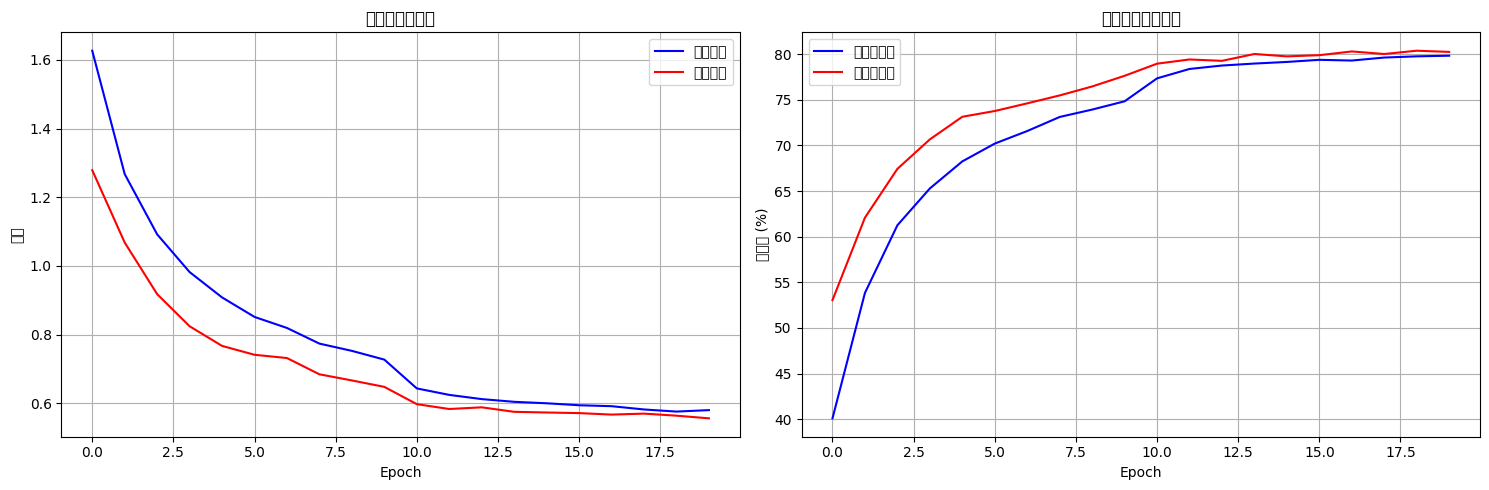

最终训练准确率: 79.84%
最终测试准确率: 80.26%


In [7]:
# 绘制训练曲线
plt.figure(figsize=(15, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', color='blue')
plt.plot(test_losses, label='测试损失', color='red')
plt.title('训练和测试损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='训练准确率', color='blue')
plt.plot(test_accs, label='测试准确率', color='red')
plt.title('训练和测试准确率')
plt.xlabel('Epoch')
plt.ylabel('准确率 (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 显示最终结果
print(f"最终训练准确率: {train_accs[-1]:.2f}%")
print(f"最终测试准确率: {test_accs[-1]:.2f}%")


分类报告:
              precision    recall  f1-score   support

          飞机       0.79      0.86      0.82      1000
          汽车       0.92      0.89      0.90      1000
           鸟       0.75      0.69      0.72      1000
           猫       0.67      0.59      0.63      1000
           鹿       0.78      0.77      0.78      1000
           狗       0.71      0.73      0.72      1000
          青蛙       0.81      0.89      0.85      1000
           马       0.84      0.83      0.84      1000
           船       0.89      0.90      0.90      1000
          卡车       0.85      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27773 (\N{CJK UNIFIED IDEOGRAPH-6C7D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 40479 (\N{CJK UNIFIED IDEOGRAPH-9E1F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 29483 (\N{CJK UNIFIED IDEOGRAPH-732B}) missing from font(s) D

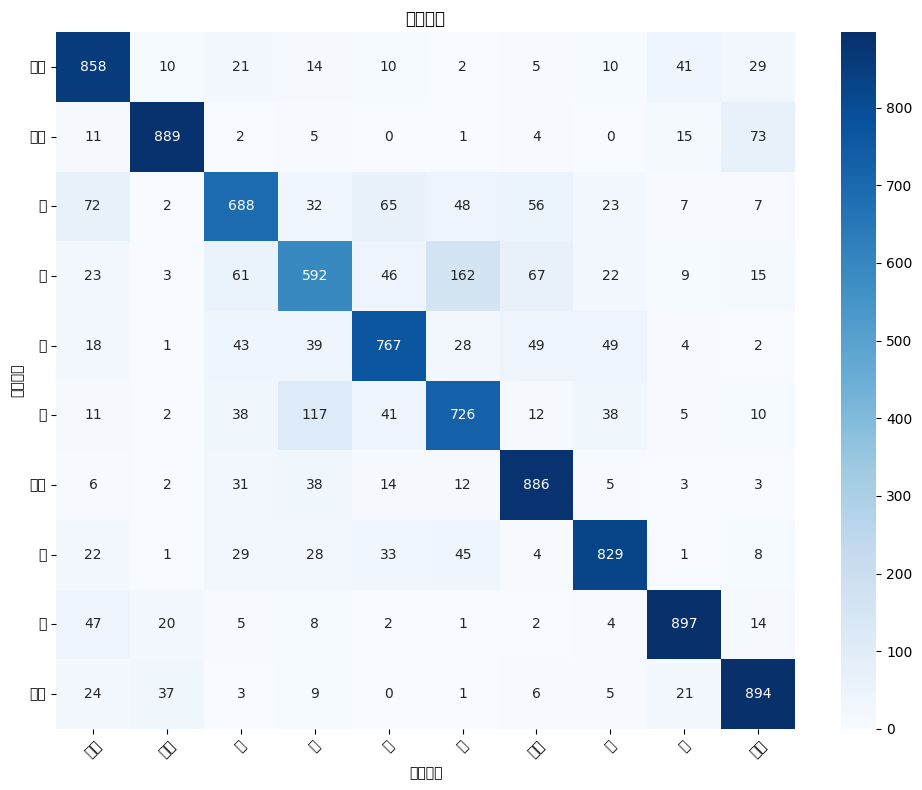

In [8]:
# 详细评估和可视化
def evaluate_model(model, testloader, class_names, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # 分类报告
    print("分类报告:")
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    # 混淆矩阵
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 执行详细评估
evaluate_model(model, testloader, class_names, device)


In [9]:
# 保存模型
def save_model(model, filepath):
    """保存模型到指定路径"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__
    }, filepath)
    print(f"模型已保存到: {filepath}")

def load_model(model, filepath, device):
    """从指定路径加载模型"""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"模型已从 {filepath} 加载")
    return model

# 保存训练好的模型
save_model(model, 'cnn_model.pth')


模型已保存到: cnn_model.pth
